In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Cargar el conjunto de datos
df = pd.read_csv('/content/drive/MyDrive/Proyecto de Título/Dataset/Datasets pre seleccionados/Heart Disease Dataset/heart.csv')

print(df.head())


Mounted at /content/drive
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
# Definir las características que deseas normalizar
features_to_normalize = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
# Aplicar la normalización solo a las características seleccionadas
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
print(df.head())

        age  sex   cp  trestbps      chol  fbs  restecg   thalach  exang  \
0  0.479167  1.0  0.0  0.292453  0.196347  0.0      0.5  0.740458    0.0   
1  0.500000  1.0  0.0  0.433962  0.175799  1.0      0.0  0.641221    1.0   
2  0.854167  1.0  0.0  0.481132  0.109589  0.0      0.5  0.412214    1.0   
3  0.666667  1.0  0.0  0.509434  0.175799  0.0      0.5  0.687023    0.0   
4  0.687500  0.0  0.0  0.415094  0.383562  1.0      0.5  0.267176    0.0   

    oldpeak  slope    ca      thal  target  
0  0.161290    1.0  0.50  1.000000       0  
1  0.500000    0.0  0.00  1.000000       0  
2  0.419355    0.0  0.00  1.000000       0  
3  0.000000    1.0  0.25  1.000000       0  
4  0.306452    0.5  0.75  0.666667       0  


In [3]:
# IMPLEMENTACION RNA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

X = df.drop('target', axis=1).values
y = df['target'].values

# Función para construir el modelo
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,),
                           kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preparar la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

# Listas para almacenar métricas
acc_per_fold = []
loss_per_fold = []

for train, test in kf.split(X):
    # Dividir los datos
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    # Construir el modelo
    model = build_model(X_train.shape[1])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, verbose=1)

    # Entrenar el modelo
    print(f'Training for fold {fold_no}...')
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=100,
        verbose=0,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluar el modelo en el conjunto de prueba
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Aumentar el número de fold
    fold_no = fold_no + 1

# == Proporcionar estadísticas de validación cruzada ==
print('------------------------------------------------------------------------')
print('Puntuación por fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Promedio de todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# == Métricas Adicionales ==
final_model = build_model(X.shape[1])
final_model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Hacer predicciones con el modelo entrenado en todos los datos
y_pred = (final_model.predict(X) > 0.5).astype(int)
y_prob = final_model.predict(X)  # Métrica ROC AUC

# Calcular métricas adicionales
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_prob)


print(f'ROC AUC: {roc_auc}')


report = classification_report(y, y_pred, digits=2)

# Imprimir las métricas
print(f'Precisión del modelo: {accuracy:.2f}')
print('\nReporte de clasificación:\n', report)

Training for fold 1...
Score for fold 1: loss of 0.4769665598869324; accuracy of 80.0000011920929%
Training for fold 2...

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Restoring model weights from the end of the best epoch: 51.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 71: early stopping
Score for fold 2: loss of 0.385158896446228; accuracy of 88.78048658370972%
Training for fold 3...

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Restoring model weights from the end of the best epoch: 59.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 79: early stopping
Score for fold 3: loss of 0.44055595993995667; accuracy of 84.87805128097534%
Training for fold 4...

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0001.
Restoring model weights from the end of the best epoch: 79.
Epoch 99: early stoppi

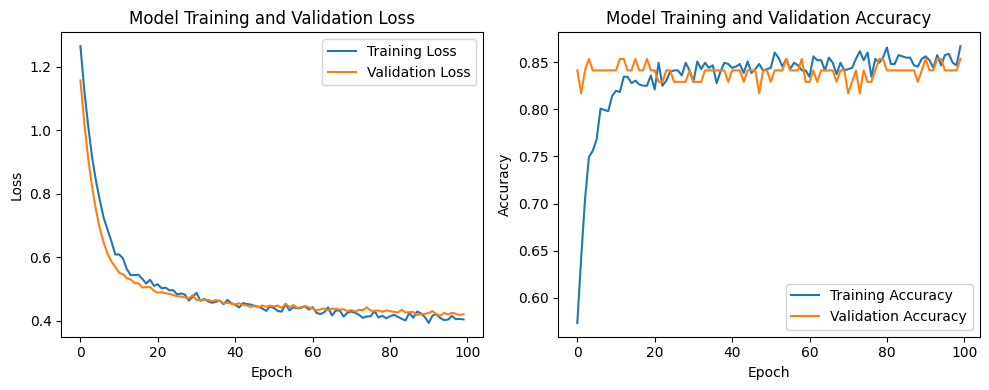

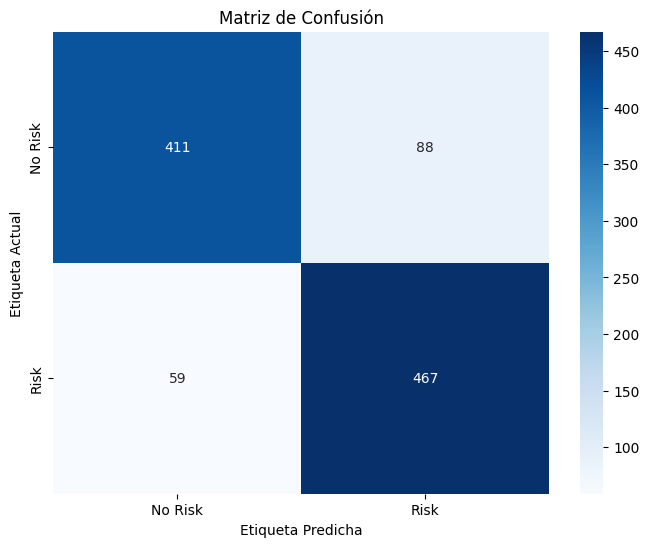

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualizar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(10, 4))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Actual')
plt.xlabel('Etiqueta Predicha')
plt.show()